## Show similarity between reviews using the embeddings

In [1]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt


x_train_df = pd.read_csv('../data_reviews/x_train.csv')
x_test_df = pd.read_csv('../data_reviews/x_test.csv')
y_train_df = pd.read_csv('../data_reviews/y_train.csv')

save_dir = os.path.abspath('../data_reviews/')
tr_embeddings_ND = np.load(os.path.join(save_dir, 'x_train_BERT_embeddings.npy'))
te_embeddings_ND = np.load(os.path.join(save_dir, 'x_test_BERT_embeddings.npy'))

# from sklearn.preprocessing import normalize
# tr_embeddings_ND = normalize(tr_embeddings_ND)
# te_embeddings_ND = normalize(te_embeddings_ND)


tr_text_list = x_train_df['text'].values.tolist()
te_text_list = x_test_df['text'].values.tolist()

/Users/juliewang/micromamba/envs/cs135_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, confusion_matrix

SEED = 12345

In [3]:
# x_train, x_val, y_train, y_val = train_test_split(tr_embeddings_ND, y_train_df, test_size=0.2, random_state=SEED)

# ON TRAINING SET

In [4]:
# Initialize the KFold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

neighbors = np.linspace(2, 150, dtype=int)
results = np.empty(neighbors.shape)

train_auroc_means = []
val_auroc_means = []
train_auroc_std = []
val_auroc_std = []

# Perform cross-validation for each choice of neighbors
for i, neighbor in enumerate(neighbors): 
    train_auroc_per_fold = []
    val_auroc_per_fold = []

    knn = KNeighborsClassifier(n_neighbors=neighbor)
    
    for train_idx, val_idx in cv.split(tr_embeddings_ND, y_train_df.values.ravel()):
        # splitting data
        X_train, X_val = tr_embeddings_ND[train_idx], tr_embeddings_ND[val_idx]
        y_train, y_val = y_train_df.values.ravel()[train_idx], y_train_df.values.ravel()[val_idx]
        
        knn.fit(X_train, y_train)
        y_train_pred_proba = knn.predict_proba(X_train)[:, 1]
        y_val_pred_proba = knn.predict_proba(X_val)[:, 1]
        
        # AUROC for each fold
        train_auroc = roc_auc_score(y_train, y_train_pred_proba)
        val_auroc = roc_auc_score(y_val, y_val_pred_proba)
        
        train_auroc_per_fold.append(train_auroc)
        val_auroc_per_fold.append(val_auroc)
    
    # Calculate the mean and standard deviation of AUROC scores across folds
    train_auroc_means.append(np.mean(train_auroc_per_fold))
    val_auroc_means.append(np.mean(val_auroc_per_fold))
    train_auroc_std.append(np.std(train_auroc_per_fold))
    val_auroc_std.append(np.std(val_auroc_per_fold))
    
    # Store the cross-validation score for selecting the best neighbors
    yhat_cv_pred = cross_val_predict(knn, tr_embeddings_ND, y_train_df.values.ravel(),
                                     cv=cv, method='predict_proba')
    score = roc_auc_score(y_train_df, yhat_cv_pred[:, 1])  # Probability for class 1
    results[i] = score

# Find the best number of neighbors
best_neighbors_idx = np.argmax(results)
best_neighbors = neighbors[best_neighbors_idx]

print(f"Best AUROC score: {results[best_neighbors_idx]}")
print(f"Optimal number of neighbors: {best_neighbors}")

Best AUROC score: 0.9295479166666668
Optimal number of neighbors: 86


In [5]:
mean_train_score = np.mean(train_auroc_means)
mean_val_score = np.mean(val_auroc_means)

# std_train_score = 

In [6]:
knn = KNeighborsClassifier(n_neighbors=best_neighbors)
yhat_cv_pred = cross_val_predict(knn, tr_embeddings_ND, y_train_df.values.ravel(), 
                                     cv=cv, method='predict_proba')
yhat_pred = list()
for value in yhat_cv_pred[:, 1]:
    if value < 0.5:
        yhat_pred.append(0)
    else:
        yhat_pred.append(1)

y_train_values = y_train_df.values.ravel()  # Flatten y_train_df to a 1D array if necessary
yhat_pred = np.array(yhat_pred)

_, fp, fn, _ = confusion_matrix(y_train_values, yhat_pred).ravel()
FP = []
FN = []


for i, pred in enumerate(yhat_pred):
    if pred == 1 and y_train_values[i] == 0:
        FP.append(i)
    if pred == 0 and y_train_values[i] == 1:
        FN.append(i)

# print(FP)

# print(x_va.iloc[FP[0]])

# pd.set_option('display.max_colwidth', None)
# pd.set_option("display.colheader_justify","left")
pd.set_option('display.max_colwidth', 10000)

va_idx_FP = FP[0:10]
va_sent_predict_FP = yhat_pred[va_idx_FP]
va_sent_true_FP = y_train_values[va_idx_FP]
FP_styled_df = x_train_df.iloc[va_idx_FP].style.set_properties(**{'text_align': 'right'})

print("FP data:")
print("FP indices chosen:", va_idx_FP)
print("FP predictions and true sentiments", va_sent_predict_FP, va_sent_true_FP)
print("Sentences that were FP: \n")
FP_styled_df

FP data:
FP indices chosen: [0, 8, 17, 23, 24, 25, 26, 38, 40, 46]
FP predictions and true sentiments [1 1 1 1 1 1 1 1 1 1] [0 0 0 0 0 0 0 0 0 0]
Sentences that were FP: 



,website_name,text
0,amazon,Oh and I forgot to also mention the weird color effect it has on your phone.
8,amazon,the only VERY DISAPPOINTING thing was there was NO SPEAKERPHONE!!!!
17,amazon,I advise EVERYONE DO NOT BE FOOLED!
23,amazon,We have tried 2 units and they both failed within 2 months.. Pros
24,amazon,Also difficult to put on.I'd recommend avoiding this product.
25,amazon,$50 Down the drain.
26,amazon,Absolutel junk.
38,amazon,[...] down the drain because of a weak snap!
40,amazon,Pretty piece of junk.
46,amazon,"If you are looking for a good quality Motorola Headset keep looking, this isn't it."


In [7]:
va_idx_FN = FN[0:10]
va_sent_predict_FN = yhat_pred[va_idx_FN]
va_sent_true_FN = y_train_values[va_idx_FN]
FN_styled_df = x_train_df.iloc[va_idx_FN].style.set_properties(**{'text_align': 'right'})

print("FN data:")
print("FN indices chosen:", va_idx_FN)
print("FN predictions and true sentiments", va_sent_predict_FN, va_sent_true_FN)
print("Sentences that were FN: \n")
FN_styled_df

FN data:
FN indices chosen: [412, 430, 435, 444, 453, 455, 458, 461, 482, 487]
FN predictions and true sentiments [0 0 0 0 0 0 0 0 0 0] [1 1 1 1 1 1 1 1 1 1]
Sentences that were FN: 



,website_name,text
412,amazon,Plan on ordering from them again and again.
430,amazon,"I have to use the smallest earpieces provided, but it stays on pretty well."
435,amazon,This is cool because most cases are just open there allowing the screen to get all scratched up.
444,amazon,I was amazed at the quick arrival of the two original lg cell phone batteries and and at a fraction of the price.
453,amazon,"Overall, I would recommend this phone over the new Walkman."
455,amazon,I ended up sliding it on the edge of my pants or back pockets instead.
458,amazon,I had to go to a store and bought a new NOKIA phone which is working great.
461,amazon,"It seems completely secure, both holding on to my belt, and keeping the iPhone inside."
482,amazon,This is hands down the best phone I've ever had.
487,amazon,It definitely was not as good as my S11.


# TESTING

In [8]:
# choose some query sentences

# use K-nearest neighbors to find the 5 reviews that most closely resemble the query review
# for test_id in range(len(x_train)):
#     query_QF = tr_embeddings_ND[test_id][np.newaxis, :]
knn = KNeighborsClassifier(best_neighbors)
knn.fit(tr_embeddings_ND, y_train_df.values.ravel())

yhat = knn.predict_proba(te_embeddings_ND)

file = open("yproba1_test.txt", "w+")
for value in yhat[:, 1]:
    line = str(value) + "\n"
    file.write(line)
file.close()


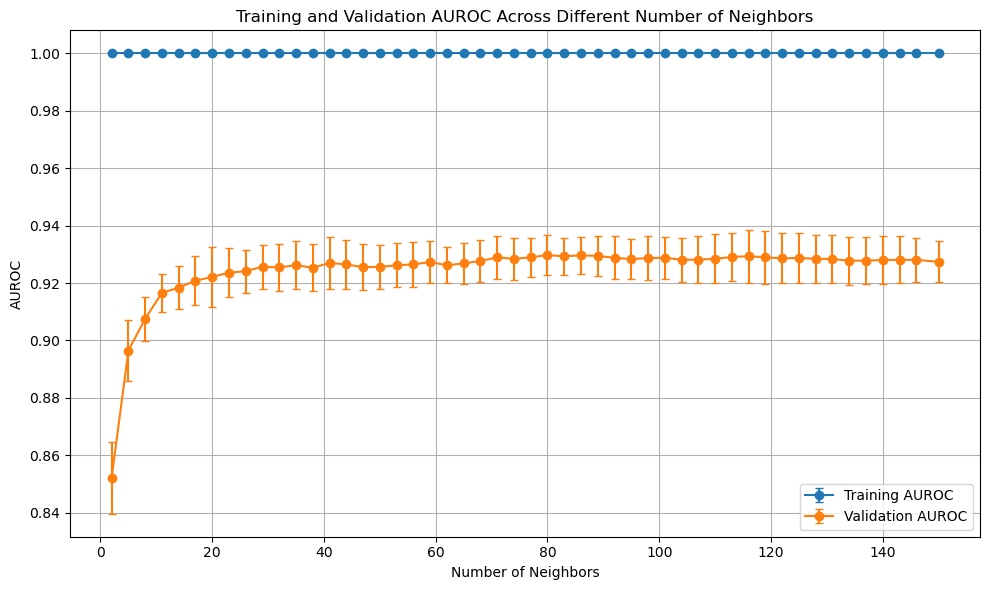

In [9]:
# Create the plot
plt.figure(figsize=(10, 6))

# Plot training and validation performance with error bars
plt.errorbar(neighbors, train_auroc_means, yerr=train_auroc_std, label='Training AUROC', fmt='-o', capsize=3)
plt.errorbar(neighbors, val_auroc_means, yerr=val_auroc_std, label='Validation AUROC', fmt='-o', capsize=3)

# Label the plot
plt.xlabel('Number of Neighbors')
plt.ylabel('AUROC')
plt.title('Training and Validation AUROC Across Different Number of Neighbors')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
